<h1 style="color:red; text-align:center; text-decoration:underline;">Réseaux de Capsules (Capsule Networks)</h1>


# 📦 Importation des bibliothèques nécessaires
Importe TensorFlow pour l'apprentissage automatique, NumPy pour la manipulation des tableaux, et Matplotlib pour l'affichage des images.


In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# 📊 Chargement et préparation du dataset MNIST
Télécharge le dataset MNIST (chiffres manuscrits), normalise les images entre 0 et 1 et encode les labels sous forme one-hot pour l'entraînement.


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[..., np.newaxis] / 255.0
x_test = x_test[..., np.newaxis] / 255.0
y_train_ohe = tf.keras.utils.to_categorical(y_train, 10)
y_test_ohe = tf.keras.utils.to_categorical(y_test, 10)

# 🧠 Définition du réseau CapsuleNet simplifié
Le modèle commence par deux couches de convolution pour extraire les caractéristiques. Les capsules sont ensuite créées et vectorisées. Une capsule est sélectionnée dynamiquement pour la reconstruction. Le modèle est construit avec deux sorties : prédiction de classe (via la norme du vecteur) et reconstruction de l'image.


def build_simple_capsnet(input_shape=(28, 28, 1), n_class=10):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(256, 9, activation='relu')(inputs)
    x = layers.Conv2D(32 * 8, 9, strides=2, activation='relu')(x)
    x = layers.Reshape([1152, 8])(x)

    x = layers.GlobalAveragePooling1D()(x)
    digit_caps = layers.Dense(n_class * 16)(x)
    digit_caps = layers.Reshape([n_class, 16])(digit_caps)

    length = layers.Lambda(lambda x: tf.norm(x, axis=-1))(digit_caps)

    def mask_caps(x):
        y = tf.argmax(tf.norm(x, axis=-1), axis=-1)
        y_onehot = tf.one_hot(y, depth=n_class)
        y_onehot = tf.expand_dims(y_onehot, -1)
        masked = tf.reduce_sum(x * y_onehot, axis=1)
        return masked

    masked = layers.Lambda(mask_caps)(digit_caps)

    decoder_input = masked
    decoder = layers.Dense(512, activation='relu')(decoder_input)
    decoder = layers.Dense(1024, activation='relu')(decoder)
    decoder_output = layers.Dense(28 * 28, activation='sigmoid')(decoder)
    decoder_output = layers.Reshape([28, 28, 1])(decoder_output)

    model = tf.keras.Model(inputs=inputs, outputs=[length, decoder_output])
    return model

model = build_simple_capsnet()

# ⚖️ Définition de la fonction de perte CapsuleNet (margin loss)
Utilise une marge pour forcer la capsule correcte à être activée fortement (valeur proche de 1) et les autres à être proches de 0.


In [4]:
def margin_loss(y_true, y_pred):
    m_plus = 0.9
    m_minus = 0.1
    lambda_val = 0.5
    L = y_true * tf.square(tf.maximum(0., m_plus - y_pred)) + \
        lambda_val * (1 - y_true) * tf.square(tf.maximum(0., y_pred - m_minus))
    return tf.reduce_mean(tf.reduce_sum(L, axis=1))

# 🛠️ Compilation du modèle
Le modèle est compilé avec l'optimiseur Adam, la fonction de perte personnalisée pour les classes et l'erreur quadratique moyenne pour la reconstruction.


In [5]:
model.compile(optimizer='adam',
              loss=[margin_loss, 'mse'],
              loss_weights=[1., 0.0005])

model.fit(x_train, [y_train_ohe, x_train], epochs=1, batch_size=128)

469/469 ━━━━━━━━━━━━━━━━━━━━ 600s 1s/step - lambda_loss: 0.5412 - loss: 0.5413 - reshape_2_loss: 0.1954


# 🚀 Entraînement du modèle
Le modèle est entraîné sur 10 époques avec validation sur le jeu de test. L'objectif est de permettre aux capsules d'apprendre à encoder la forme des chiffres.


In [6]:
model.compile(optimizer='adam',
              loss=[margin_loss, 'mse'],
              loss_weights=[1., 0.0005])

model.fit(
    x_train, [y_train_ohe, x_train],
    validation_data=(x_test, [y_test_ohe, x_test]),
    epochs=10,
    batch_size=128
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 768s 2s/step - lambda_loss: 0.1385 - loss: 0.1385 - reshape_2_loss: 0.0666 - val_lambda_loss: 0.0497 - val_loss: 0.0499 - val_reshape_2_loss: 0.0660
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 801s 2s/step - lambda_loss: 0.0439 - loss: 0.0439 - reshape_2_loss: 0.0651 - val_lambda_loss: 0.0329 - val_loss: 0.0331 - val_reshape_2_loss: 0.0634
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 779s 2s/step - lambda_loss: 0.0331 - loss: 0.0331 - reshape_2_loss: 0.0625 - val_lambda_loss: 0.0276 - val_loss: 0.0278 - val_reshape_2_loss: 0.0597
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 921s 2s/step - lambda_loss: 0.0276 - loss: 0.0276 - reshape_2_loss: 0.0590 - val_lambda_loss: 0.0262 - val_loss: 0.0264 - val_reshape_2_loss: 0.0564
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1269s 3s/step - lambda_loss: 0.0252 - loss: 0.0252 - reshape_2_loss: 0.0561 - val_lambda_loss: 0.0234 - val_loss: 0.0235 - val_reshape_2_loss: 0.0545
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 695s 1s/step -

# 🖼️ Visualisation : images originales vs reconstructions
Affiche 5 images du test avec leur prédiction (capsule activée) et leur reconstruction. Permet d’évaluer visuellement la qualité d’encodage des capsules.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


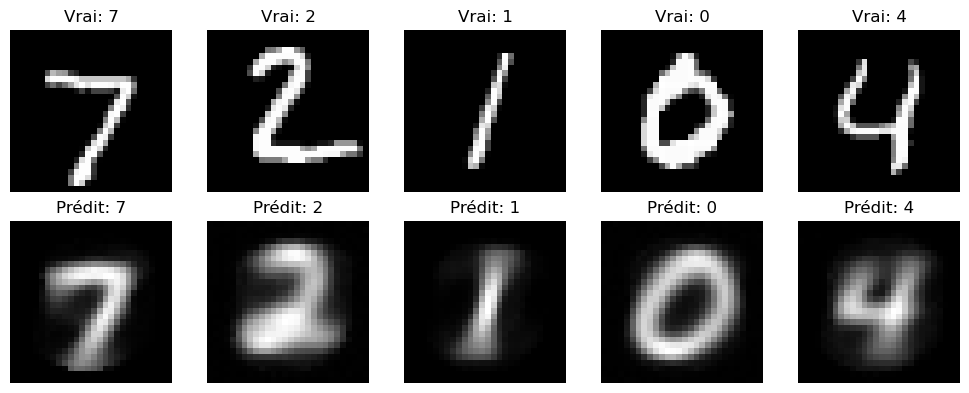

In [7]:
def plot_reconstructions(model, data, n_images=5):
    x_test, y_test = data
    x_sample = x_test[:n_images]
    y_true = y_test[:n_images]
    y_pred, x_reconstructed = model.predict(x_sample)
    y_pred_labels = y_pred.argmax(axis=1)

    fig = plt.figure(figsize=(n_images * 2, 4))
    for i in range(n_images):
        ax = fig.add_subplot(2, n_images, i + 1)
        ax.imshow(x_sample[i].reshape(28, 28), cmap="gray")
        ax.set_title(f"Vrai: {y_true[i]}")
        ax.axis("off")

        ax = fig.add_subplot(2, n_images, i + 1 + n_images)
        ax.imshow(x_reconstructed[i].reshape(28, 28), cmap="gray")
        ax.set_title(f"Prédit: {y_pred_labels[i]}")
        ax.axis("off")
    plt.tight_layout()
    plt.savefig("reconstructions_mnist_capsnet.png")
    plt.show()

plot_reconstructions(model, (x_test, y_test))

<h3 style="color:#0056b3; text-decoration:underline;">Résultat et Interprétation</h3>

Cette expérimentation illustre le fonctionnement d’un réseau de capsules (CapsuleNet) appliqué à la classification des chiffres manuscrits du jeu MNIST.  
L’architecture repose sur des capsules vectorielles capables d’encoder non seulement la probabilité d’appartenance à une classe (via la norme du vecteur), mais également des informations spatiales telles que l’orientation, la position ou encore la morphologie du chiffre.

La première ligne de visualisation présente les images originales, tandis que la seconde montre les reconstructions générées à partir des vecteurs produits par les capsules activées.  
Chaque reconstruction est obtenue à partir de la capsule correspondant à la classe prédite, et témoigne de la capacité du réseau à reproduire les caractéristiques essentielles de l’image d’origine.

On observe que les reconstructions sont visuellement cohérentes et structurellement proches des entrées, ce qui indique que CapsuleNet a su apprendre des représentations significatives et exploitables.  
Ce comportement met en évidence l’un des principaux atouts de cette architecture : la préservation explicite des relations hiérarchiques entre les parties d’un objet, là où les réseaux convolutifs classiques se contentent de filtrer localement.

En somme, CapsuleNet dépasse le cadre de la simple classification en fournissant une représentation explicite de la structure des objets.  
Il se positionne ainsi comme une alternative robuste et interprétable aux CNN traditionnels, particulièrement adaptée aux tâches où la compréhension spatiale joue un rôle central.
